In [4]:
import cv2
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, exists
from PIL import Image

In [2]:
I = '../data/images/beach.jpeg'
M = '../data/output/match/beach_canon5d.jpg'
T = '../data/output/match/beach_canon5d_1_15.jpg'

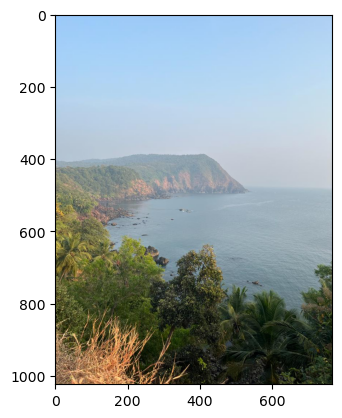

In [3]:
#plot I
plt.imshow(cv2.imread(I)[:,:,::-1])

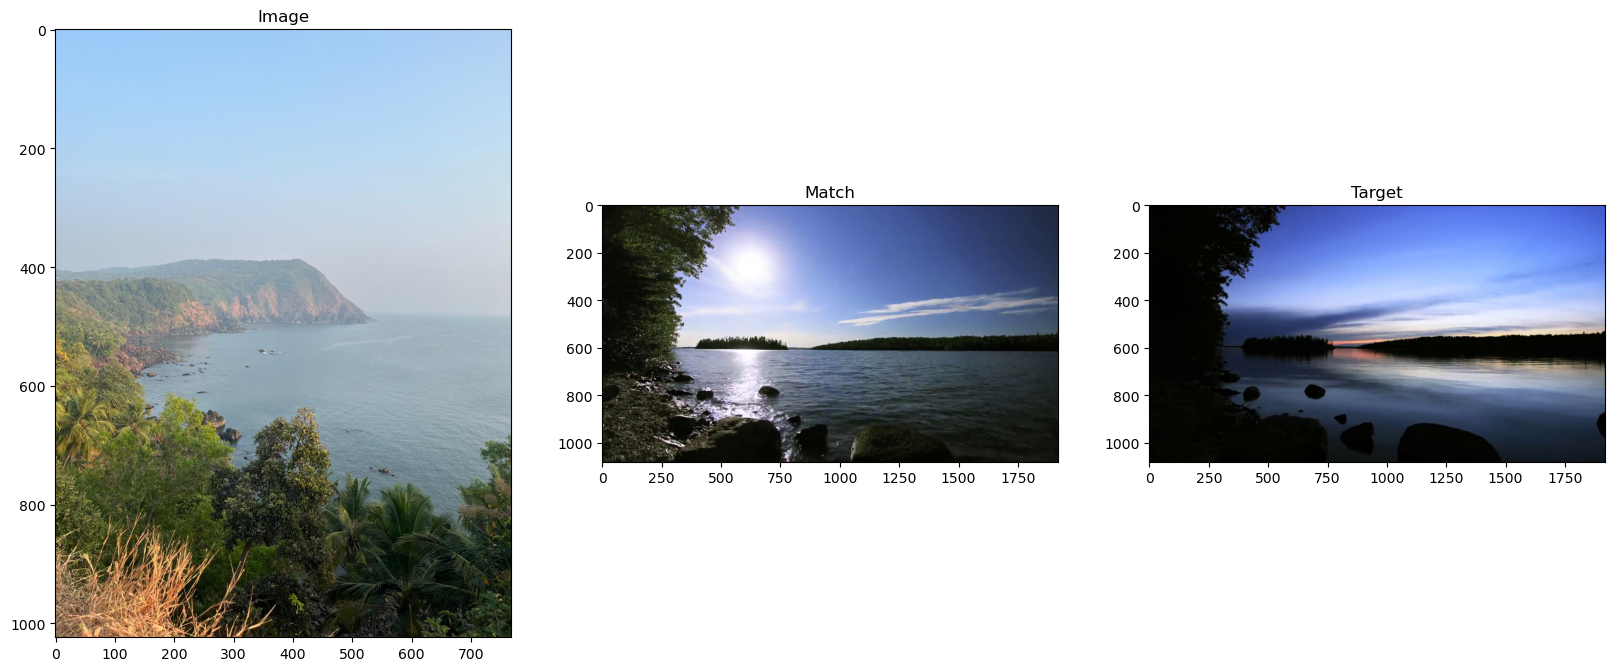

In [13]:
#plot the images
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(cv2.imread(I)[:,:,::-1])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(cv2.imread(M)[:,:,::-1])
plt.title('Match')
plt.subplot(1,3,3)
plt.imshow(cv2.imread(T)[:,:,::-1])
plt.title('Target')
plt.show()

From Collab

In [4]:
class PatchMatch:
    def __init__(self, patch_size, alpha=0.5, radius=10):
        self.patch_size = patch_size
        self.alpha = alpha
        self.radius = radius

    def calc_dist(self, x_c, y_c, x, y):
        # square distance
        p = self.patch_size // 2
        x_p = x[x_c[0]: x_c[0] + self.patch_size, x_c[1]: x_c[1] + self.patch_size, :]
        y_p = y[y_c[0] - p: y_c[0] + p + 1, y_c[1] - p: y_c[1] + p + 1, :]
        diff = y_p - x_p
        dist = np.sum(np.square(np.nan_to_num(diff))) / np.sum(~np.isnan(diff))
        return dist

    @staticmethod
    def reconstruction(x, y, f):
        x_h, x_w, _ = x.shape
        x_new = np.zeros_like(x)
        for i in range(x_h):
            for j in range(x_w):
                x_new[i, j, :] = y[f[i, j][0], f[i, j][1], :]
        return x_new

    def init(self, x, y):
        x_h, x_w, x_c = x.shape
        y_h, y_w, y_c = y.shape

        p = self.patch_size // 2

        x_padding = np.ones([x_h + 2 * p, x_w + 2 * p, x_c]) * np.nan
        x_padding[p: x_h + p, p: x_w + p, :] = x

        f = np.zeros([x_h, x_w], dtype=object)  # x pixel project to y
        d = np.zeros([x_h, x_w])  # distance of x pixel and projected y pixel

        for i in range(x_h):
            for j in range(x_w):
                # the center point of patch
                x_p_c = np.array([i, j])
                y_p_c = np.array([np.random.randint(p, y_h - p), np.random.randint(p, y_w - p)])
                f[i, j] = y_p_c
                d[i, j] = self.calc_dist(x_c=x_p_c, y_c=y_p_c, x=x_padding, y=y)
        return f, d, x_padding

    def propagation(self, x, y, curr_p, f, d, odd=False):
        x_h = x.shape[0] - self.patch_size + 1
        x_w = x.shape[1] - self.patch_size + 1
        curr_h, curr_w = curr_p
        if not odd:
            d_left = d[curr_h, max(curr_w - 1, 0)]
            d_up = d[max(curr_h - 1, 0), curr_w]
            d_curr = d[curr_h, curr_w]
            d_min = min([d_left, d_up, d_curr])
            if d_min == d_curr:
                return
            elif d_min == d_up:
                f[curr_h, curr_w] = f[max(curr_h - 1, 0), curr_w]
            else:
                f[curr_h, curr_w] = f[curr_h, max(curr_w - 1, 0)]
        else:
            d_right = d[curr_h, min(curr_w + 1, x_w - 1)]
            d_down = d[min(curr_h + 1, x_h - 1), curr_w]
            d_curr = d[curr_h, curr_w]
            d_min = min([d_right, d_down, d_curr])
            if d_min == d_curr:
                return
            elif d_min == d_down:
                f[curr_h, curr_w] = f[min(curr_h + 1, x_h - 1), curr_w]
            else:
                f[curr_h, curr_w] = f[curr_h, min(curr_w + 1, x_w - 1)]
        d[curr_h, curr_w] = self.calc_dist(x_c=curr_p, y_c=f[curr_h, curr_w], x=x, y=y)

    def random_search(self, curr_p, x, y, f, d):
        curr_h, curr_w = curr_p
        y_h, y_w, _ = y.shape
        p = self.patch_size // 2

        # radius = h * alpha ** i
        i = int(np.log(self.radius / y_h) / np.log(self.alpha))
        search_h = y_h * self.alpha ** i
        search_w = y_w * self.alpha ** i

        y_curr_h = f[curr_h, curr_w][0]
        y_curr_w = f[curr_h, curr_w][1]

        while search_h > 1 and search_w > 1:
            random_h = np.random.randint(
                max(y_curr_h - search_h, p),
                min(y_curr_h + search_h, y_h - p)
            )
            random_w = np.random.randint(
                max(y_curr_w - search_w, p),
                min(y_curr_w + search_w, y_w - p)
            )
            random_p = np.array([random_h, random_w])
            random_d = self.calc_dist(x_c=curr_p, y_c=random_p, x=x, y=y)
            if random_d < d[curr_h, curr_w]:
                d[curr_h, curr_w] = random_d
                f[curr_h, curr_w] = random_p

            i += 1
            search_h = y_h * self.alpha ** i
            search_w = y_w * self.alpha ** i

    def train(self, x, y, n_iter=10):
        start_time = time.time()
        f, d, x_padding = self.init(x, y)
        x_h, x_w, _ = x.shape
        print(f"| Init cost {time.time() - start_time:.3f} seconds.")

        for itr in range(1, n_iter + 1):
            curr_time = time.time()
            if itr % 2 != 0:
                for i in range(x_h):
                    for j in range(x_w):
                        curr_p = np.array([i, j])
                        self.propagation(x=x_padding, y=y, curr_p=curr_p, f=f, d=d, odd=False)
                        self.random_search(curr_p=curr_p, x=x_padding, y=y, f=f, d=d)
            else:
                for i in range(x_h - 1, -1, -1):
                    for j in range(x_w - 1, -1, -1):
                        curr_p = np.array([i, j])
                        self.propagation(x=x_padding, y=y, curr_p=curr_p, f=f, d=d, odd=True)
                        self.random_search(curr_p=curr_p, x=x_padding, y=y, f=f, d=d)
            print(f"| Finish {itr}/{n_iter} iteration, cost {time.time() - curr_time:.3} seconds.")
        return self.reconstruction(x=x, y=y, f=f), f

| Init cost 32.382 seconds.
| Finish 1/1 iteration, cost 2.67e+02 seconds.


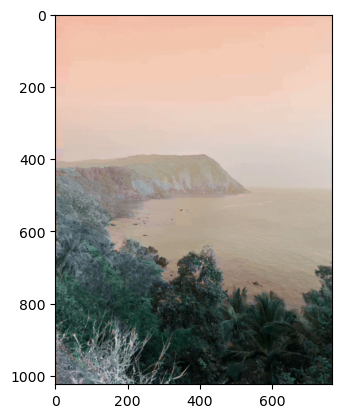

In [6]:
patchmatch = PatchMatch(patch_size=3)
c, f = patchmatch.train(x=I, y=M, n_iter=5)

plt.imshow(c)
plt.show()

From Github https://github.com/MingtaoGuo/PatchMatch/

In [5]:
def cal_distance(a, b, A_padding, B, p_size):
    p = p_size // 2
    patch_a = A_padding[a[0]:a[0]+p_size, a[1]:a[1]+p_size, :]
    patch_b = B[b[0]-p:b[0]+p+1, b[1]-p:b[1]+p+1, :]
    temp = patch_b - patch_a
    num = np.sum(1 - np.int32(np.isnan(temp)))
    dist = np.sum(np.square(np.nan_to_num(temp))) / num
    return dist

def reconstruction(f, A, B):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    temp = np.zeros_like(A)
    for i in range(A_h):
        for j in range(A_w):
            temp[i, j, :] = B[f[i, j][0], f[i, j][1], :]
    # Image.fromarray(temp).show()
    #plot the result
    plt.imshow(temp)
    plt.show()
    return temp


def initialization(A, B, p_size):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = p_size // 2
    random_B_r = np.random.randint(p, B_h-p, [A_h, A_w])
    random_B_c = np.random.randint(p, B_w-p, [A_h, A_w])
    A_padding = np.ones([A_h+p*2, A_w+p*2, 3]) * np.nan
    A_padding[p:A_h+p, p:A_w+p, :] = A
    f = np.zeros([A_h, A_w], dtype=object)
    dist = np.zeros([A_h, A_w])
    for i in range(A_h):
        for j in range(A_w):
            a = np.array([i, j])
            b = np.array([random_B_r[i, j], random_B_c[i, j]], dtype=np.int32)
            f[i, j] = b
            dist[i, j] = cal_distance(a, b, A_padding, B, p_size)
    return f, dist, A_padding

def propagation(f, a, dist, A_padding, B, p_size, is_odd):
    A_h = np.size(A_padding, 0) - p_size + 1
    A_w = np.size(A_padding, 1) - p_size + 1
    x = a[0]
    y = a[1]
    if is_odd:
        d_left = dist[max(x-1, 0), y]
        d_up = dist[x, max(y-1, 0)]
        d_current = dist[x, y]
        idx = np.argmin(np.array([d_current, d_left, d_up]))
        if idx == 1:
            f[x, y] = f[max(x - 1, 0), y]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)
        if idx == 2:
            f[x, y] = f[x, max(y - 1, 0)]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)
    else:
        d_right = dist[min(x + 1, A_h-1), y]
        d_down = dist[x, min(y + 1, A_w-1)]
        d_current = dist[x, y]
        idx = np.argmin(np.array([d_current, d_right, d_down]))
        if idx == 1:
            f[x, y] = f[min(x + 1, A_h-1), y]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)
        if idx == 2:
            f[x, y] = f[x, min(y + 1, A_w-1)]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)

def random_search(f, a, dist, A_padding, B, p_size, alpha=0.5):
    x = a[0]
    y = a[1]
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = p_size // 2
    i = 4
    search_h = B_h * alpha ** i
    search_w = B_w * alpha ** i
    b_x = f[x, y][0]
    b_y = f[x, y][1]
    while search_h > 1 and search_w > 1:
        search_min_r = max(b_x - search_h, p)
        search_max_r = min(b_x + search_h, B_h-p)
        random_b_x = np.random.randint(search_min_r, search_max_r)
        search_min_c = max(b_y - search_w, p)
        search_max_c = min(b_y + search_w, B_w - p)
        random_b_y = np.random.randint(search_min_c, search_max_c)
        search_h = B_h * alpha ** i
        search_w = B_w * alpha ** i
        b = np.array([random_b_x, random_b_y])
        d = cal_distance(a, b, A_padding, B, p_size)
        if d < dist[x, y]:
            dist[x, y] = d
            f[x, y] = b
        i += 1

def NNS(img, ref, p_size, itr):
    A_h = np.size(img, 0)
    A_w = np.size(img, 1)
    f, dist, img_padding = initialization(img, ref, p_size)
    for itr in range(1, itr+1):
        if itr % 2 == 0:
            for i in range(A_h - 1, -1, -1):
                for j in range(A_w - 1, -1, -1):
                    a = np.array([i, j])
                    propagation(f, a, dist, img_padding, ref, p_size, False)
                    random_search(f, a, dist, img_padding, ref, p_size)
        else:
            for i in range(A_h):
                for j in range(A_w):
                    a = np.array([i, j])
                    propagation(f, a, dist, img_padding, ref, p_size, True)
                    random_search(f, a, dist, img_padding, ref, p_size)
        print("iteration: %d"%(itr))
    return f

iteration: 1
iteration: 2
iteration: 3
1585.8405630588531


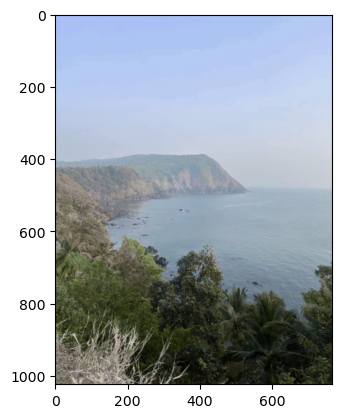

array([[[170, 191, 248],
        [170, 191, 248],
        [170, 191, 248],
        ...,
        [178, 201, 242],
        [178, 201, 242],
        [178, 201, 242]],

       [[170, 191, 248],
        [170, 191, 248],
        [170, 191, 248],
        ...,
        [178, 201, 242],
        [178, 201, 242],
        [178, 201, 242]],

       [[170, 191, 248],
        [170, 191, 248],
        [170, 191, 248],
        ...,
        [180, 203, 244],
        [180, 203, 244],
        [180, 203, 244]],

       ...,

       [[ 96,  86,  77],
        [ 96,  86,  77],
        [ 96,  86,  77],
        ...,
        [ 41,  46,  26],
        [ 41,  46,  26],
        [ 42,  47,  27]],

       [[ 96,  86,  77],
        [ 96,  86,  77],
        [ 96,  86,  77],
        ...,
        [ 41,  46,  26],
        [ 40,  45,  25],
        [ 42,  47,  27]],

       [[ 89,  79,  70],
        [ 89,  79,  70],
        [ 96,  86,  77],
        ...,
        [ 39,  43,  28],
        [ 40,  45,  25],
        [ 40,  45,  25]]

In [15]:
img = np.array(Image.open(I))
ref = np.array(Image.open(M))
p_size = 3
itr = 3

start = time.time()
f = NNS(img, ref, p_size, itr)
end = time.time()

#save correspondences
np.save('correspondences.npy', f)

print(end - start)
reconstruction(f, img, ref)

In [8]:
I = '../data/images/singapore.jpg'
M = '../data/output/match/best_frame.jpg'
T = '../data/output/match/beach_canon5d_1_15.jpg'

iteration: 1
iteration: 2
iteration: 3
1479.5031185150146


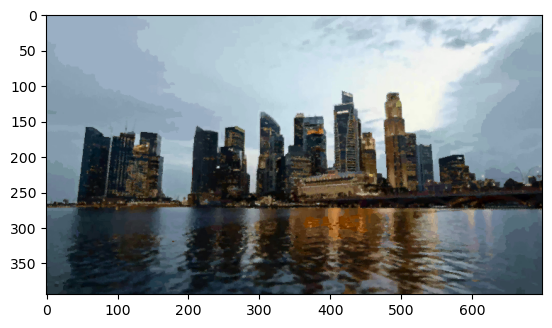

array([[[154, 175, 196],
        [154, 175, 196],
        [154, 175, 196],
        ...,
        [171, 195, 207],
        [171, 195, 207],
        [171, 195, 207]],

       [[154, 175, 196],
        [154, 175, 196],
        [154, 175, 196],
        ...,
        [171, 195, 207],
        [171, 195, 207],
        [171, 195, 207]],

       [[154, 175, 196],
        [154, 175, 196],
        [154, 175, 196],
        ...,
        [171, 195, 207],
        [171, 195, 207],
        [171, 195, 207]],

       ...,

       [[ 40,  51,  57],
        [ 40,  51,  57],
        [ 40,  51,  57],
        ...,
        [ 54,  72,  84],
        [ 54,  72,  84],
        [ 54,  72,  84]],

       [[ 40,  51,  57],
        [ 40,  51,  57],
        [ 40,  51,  57],
        ...,
        [ 54,  72,  84],
        [ 54,  72,  84],
        [ 54,  72,  84]],

       [[ 40,  51,  57],
        [ 40,  51,  57],
        [ 25,  42,  50],
        ...,
        [ 54,  72,  84],
        [ 54,  72,  84],
        [ 54,  72,  84]]

In [9]:
img = np.array(Image.open(I))
ref = np.array(Image.open(M))
p_size = 3
itr = 3

start = time.time()
f = NNS(img, ref, p_size, itr)
end = time.time()

#save correspondences
np.save('correspondences.npy', f)

print(end - start)
reconstruction(f, img, ref)

In [18]:
#local affine tranfer
#I is the input image, M is the reference image, T is the target image
#f is the correspondence field. f[i, j] = [x, y] means the pixel (i, j) in I is corresponding to the pixel (x, y) in M.
#convert pixel colors from I to T according to the correspondence field f

def direct_transfer(I, M, T, p_size):
    I = np.array(Image.open(I))
    M = np.array(Image.open(M))
    T = np.array(Image.open(T))
    
    #load correspondences
    f = np.load('correspondences.npy', allow_pickle=True)
    output = np.zeros(np.shape(I))
    I_h = np.size(I, 0)
    I_w = np.size(I, 1)
    T_h = np.size(T, 0)
    T_w = np.size(T, 1)
    p = p_size // 2
    for i in range(I_h):
        for j in range(I_w):
            x = f[i, j][0]
            y = f[i, j][1]
            if x < p or x >= T_h - p or y < p or y >= T_w - p:
                continue
            output[i, j] = T[x, y]
    return output

def local_affine_transfer(I, M, T, p_size):
    #load correspondences
    f = np.load('correspondences.npy')

    I_h = np.size(I, 0)
    I_w = np.size(I, 1)
    T_h = np.size(T, 0)
    T_w = np.size(T, 1)
    p = p_size // 2
    
    for i in range(I_h):
        for j in range(I_w):
            x = f[i, j][0]
            y = f[i, j][1]
            if x < p or x >= T_h - p or y < p or y >= T_w - p:
                continue
            I_patch = I[max(i - p, 0):min(i + p + 1, I_h), max(j - p, 0):min(j + p + 1, I_w)]
            M_patch = M[max(x - p, 0):min(x + p + 1, T_h), max(y - p, 0):min(y + p + 1, T_w)]
            T_patch = T[max(x - p, 0):min(x + p + 1, T_h), max(y - p, 0):min(y + p + 1, T_w)]
            I_patch = I_patch.reshape([-1, 3])
            M_patch = M_patch.reshape([-1, 3])
            T_patch = T_patch.reshape([-1, 3])
            I_patch = I_patch.astype(np.float32)
            M_patch = M_patch.astype(np.float32)
            T_patch = T_patch.astype(np.float32)
            I_patch = I_patch.T
            M_patch = M_patch.T
            T_patch = T_patch.T
            A = np.dot(I_patch, M_patch.T)
            A = np.linalg.inv(A)
            A = np.dot(A, I_patch)
            A = np.dot(A, T_patch.T)
            T[i, j] = np.dot(A, I[i, j].T)
    return T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


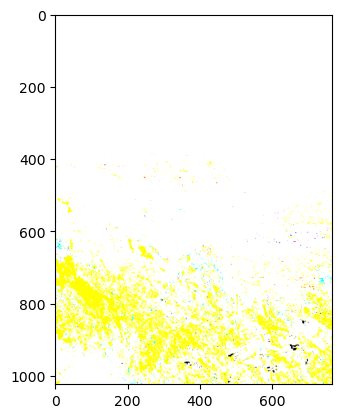

In [19]:
output = direct_transfer(I, M, T, p_size)

plt.imshow(output)
plt.show()

In [ ]:
ouput = local_affine_transfer(I, M, T, p_size)

plt.imshow(ouput)
plt.show()